# Visualize Performance of Cell Health Prediction Models

**Gregory Way, 2019**

For regression classification problem. 

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))

In [2]:
consensus <- "modz"

In [3]:
results_dir <- "results"
figure_dir <- file.path("figures", "regression", consensus)
individual_fig_dir <- file.path(
    "figures",
    "individual_target_performance",
    "regression",
    consensus
)

dir.create(results_dir, showWarnings = FALSE)
dir.create(figure_dir, recursive = TRUE, showWarnings = FALSE)
dir.create(individual_fig_dir, recursive = TRUE, showWarnings = FALSE)

## Load Data

In [4]:
# Complete regression results
regression_file <- file.path(
    results_dir, 
    paste0("full_cell_health_regression_", consensus, ".tsv.gz")
)
regression_metrics_df <- readr::read_tsv(regression_file, col_types = readr::cols()) %>%
    dplyr::filter(cell_line == "all")

# Model coefficients
coef_file <- file.path(
    results_dir,
    paste0("full_cell_health_coefficients_", consensus, ".tsv.gz")
)
full_coef_df <- readr::read_tsv(coef_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform == "raw")

# Metadata information
metadata_file <- file.path(
    "..",
    "1.generate-profiles",
    "data",
    "profile_id_metadata_mapping.tsv"
)
metadata_df <- readr::read_tsv(metadata_file, col_types = readr::cols())

# Ground truth (y) values
y_file <- file.path(
    results_dir,
    paste0("full_cell_health_y_labels_", consensus, ".tsv.gz")
)
y_df <- readr::read_tsv(y_file, col_types = readr::cols()) %>%
    dplyr::filter(y_transform == "raw")

# Label variables with specific cell health classes
label_file <- file.path(
    "..",
    "1.generate-profiles",
    "data",
    "labels",
    "feature_mapping_annotated.csv"
)
label_df <- readr::read_csv(label_file, col_types = readr::cols())

## Process y Matrix for Plotting

In [5]:
# Combine data for downstream processing
y_binary_subset_true_df <- y_df %>%
    dplyr::filter(y_type == "y_true")

y_binary_subset_pred_df <- y_df %>%
    dplyr::filter(y_type == "y_pred")

# Process data for plotting
y_plot_df <- y_binary_subset_true_df %>%
    dplyr::inner_join(
        y_binary_subset_pred_df,
        by = c("Metadata_profile_id",
               "target",
               "data_type",
               "shuffle",
               "y_transform"),
        suffix = c("_true", "_pred")) %>%
    dplyr::left_join(metadata_df, by = "Metadata_profile_id")

y_plot_df$data_type <- dplyr::recode(
    y_plot_df$data_type,
    "train" = "Train",
    "test" = "Test"
)

print(dim(y_plot_df))
head(y_plot_df, 3)

[1] 49980    11


Metadata_profile_id,recode_target_value_true,target,data_type,shuffle,y_transform,y_type_true,recode_target_value_pred,y_type_pred,Metadata_cell_line,Metadata_pert_name
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
profile_340,0.46560759,cc_all_high_h2ax,Train,shuffle_true,raw,y_true,0.4894372,y_pred,HCC44,RHOA-2
profile_6,0.08417835,cc_all_high_h2ax,Train,shuffle_true,raw,y_true,0.3155335,y_pred,A549,ATP50-1
profile_79,0.15562496,cc_all_high_h2ax,Train,shuffle_true,raw,y_true,0.2783470,y_pred,A549,MTOR-1


## Process Regression Metrics for Plotting

In [6]:
regression_metrics_df$data_fit <- dplyr::recode(
    regression_metrics_df$data_fit,
    "train" = "Train",
    "test" = "Test"
)

regression_metrics_df$shuffle <- dplyr::recode(
    regression_metrics_df$shuffle,
    "shuffle_true" = "Shuffle",
    "shuffle_false" = "Real"
)

regression_metrics_df <- regression_metrics_df %>%
    dplyr::rename(data_type = data_fit)

regression_metrics_df$value <- round(regression_metrics_df$value, 2)

print(dim(regression_metrics_df))
head(regression_metrics_df, 3)

[1] 560   7


value,metric,target,data_type,shuffle,y_transform,cell_line
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0.38,mse,cc_all_high_h2ax,Train,Shuffle,raw,all
0.68,mse,cc_all_high_h2ax,Test,Shuffle,raw,all
0.47,r_two,cc_all_high_h2ax,Train,Shuffle,raw,all


## Plot a Summary of All Target Variables

In [7]:
measurement_colors <- c(
    "shape" = "#6a3d9a",
    "apoptosis" = "#a6cee3",
    "death" = "#33a02c",
    "cell_viability" = "#b2df8a",
    "dna_damage" = "#fb9a99",
    "ros" = "red",
    "cell_cycle" = "#1f78b4",
    "g1_arrest" = "#fdbf6f",
    "g2_arrest" = "#ff7f00",
    "g2_m_arrest" = "#005c8c",
    "mitosis" = "green",
    "s_arrest" = "#cab2d6",
    "other" = "black",
    "metadata" = "grey"
)

measurement_labels <- c(
    "shape" = "Shape",
    "apoptosis" = "Apoptosis",
    "death" = "Death",
    "cell_viability" = "Cell Viability",
    "dna_damage" = "DNA Damage",
    "ros" = "Reactive Oxygen Species", 
    "cell_cycle" = "Cell Cycle Gates",
    "g1_arrest" = "G1 Arrest",
    "g2_arrest" = "G2 Arrest",
    "g2_m_arrest" = "G2/M Arrest",
    "mitosis" = "Mitosis",
    "s_arrest" = "S Arrest",
    "other" = "Other",
    "metadata" = "Metadata"
)

dye_theme = theme(
    axis.title = element_text(size = 4),
    axis.title.x = element_text(margin = margin(0, 0, 0, 0)),
    axis.title.y = element_text(margin = margin(0, 0, 0, 0)),
    axis.text = element_text(size = 4),
    axis.ticks = element_line(size = 0.1),
    axis.ticks.length = unit(0.05, "cm"),
    plot.title = element_text(size = 5, margin = margin(0, 0, 0, 0)),
    plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "mm"),
    legend.title = element_text(size = 3.5),
    legend.text = element_text(size = 3.5), 
    legend.key.height = unit(0.2, "line"),
    legend.key.width = unit(-0.2, "line"),
    panel.grid.minor = element_line(size = 0.1),
    panel.grid.major = element_line(size = 0.2),
    legend.margin = margin(-5, 7, 0, 0),
    legend.box.margin=margin(0, -5, 5, -5)
)

### Mean Squared Error (MSE)

In [8]:
mse_df <- regression_metrics_df %>%
    dplyr::filter(metric == "mse",
                  y_transform == "raw",
                  data_type == "Test")

# Take absolute value of mean squared error
# see https://github.com/scikit-learn/scikit-learn/issues/2439
mse_df$value = abs(mse_df$value)

# Sort mse by minimum MSE in test set
target_order <- mse_df %>%
    dplyr::filter(data_type == "Test",
                  shuffle == "Real") %>%
    dplyr::arrange(desc(value)) %>%
    dplyr::select(target)

mse_df$target <- factor(
    mse_df$target,
    levels=target_order$target
)

print(dim(mse_df))
head(mse_df, 4)

[1] 140   7


value,metric,target,data_type,shuffle,y_transform,cell_line
<dbl>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>
0.68,mse,cc_all_high_h2ax,Test,Shuffle,raw,all
0.47,mse,cc_all_high_h2ax,Test,Real,raw,all
0.32,mse,cc_all_large_notround_polynuclear_mean,Test,Shuffle,raw,all
0.19,mse,cc_all_large_notround_polynuclear_mean,Test,Real,raw,all


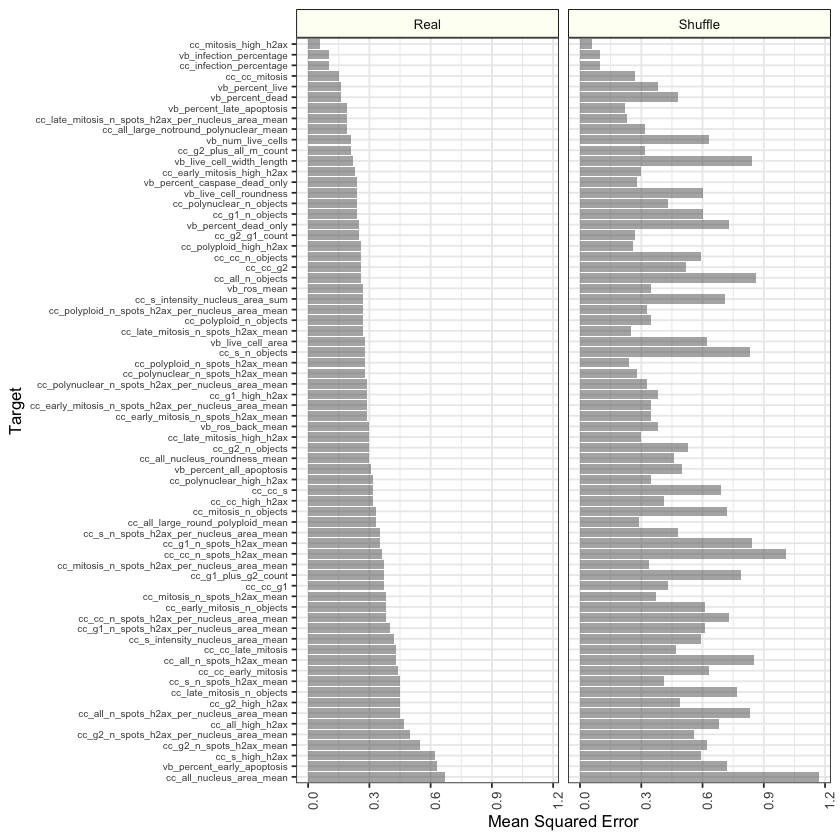

In [9]:
ggplot(mse_df,
       aes(x = target,
           y = value)) +
    geom_bar(stat = "identity",
             alpha = 0.5,
             position = position_dodge()) +
    facet_grid(~shuffle, scales="free_y") +
    coord_flip() +
    theme_bw() +
    ylab("Mean Squared Error") +
    xlab("Target") +
    theme(axis.text.x = element_text(size = 8, angle = 90),
          axis.text.y = element_text(size = 6),
          axis.title = element_text(size = 10),
          legend.position = "none",
          legend.text = element_text(size = 7),
          legend.title = element_text(size = 9),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

file <- file.path(
    figure_dir,
    paste0("mse_test_summary_", consensus, ".png")
)

ggsave(file, dpi = 300, width = 6, height = 6)

In [10]:
# Merge table with target labels
mse_summary_df <- mse_df %>%
    dplyr::left_join(label_df, by = c("target" = "id")) %>%
    dplyr::filter(!is.na(measurement))

# Split shuffle column for scatter plot
mse_spread_df <- mse_summary_df %>% tidyr::spread(shuffle, value)

head(mse_spread_df, 2)

Warning message:
“Column `target`/`id` joining factor and character vector, coercing into character vector”

metric,target,data_type,y_transform,cell_line,readable_name,original_name,feature_type,measurement,gate_required,⋯,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description,Real,Shuffle
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
mse,cc_all_high_h2ax,Test,raw,all,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,⋯,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,0.47,0.68
mse,cc_all_large_notround_polynuclear_mean,Test,raw,all,ALL - Polynuclear,ALL - large not round (polynuclear) - Mean per Well,cell_cycle,shape,1,⋯,0,0,0,0,0,0,0,Fraction of cells with large non-round nuclei (Polynuclear),0.19,0.32


Warning message:
“Removed 15 rows containing missing values (geom_point).”Warning message:
“Removed 15 rows containing missing values (geom_point).”

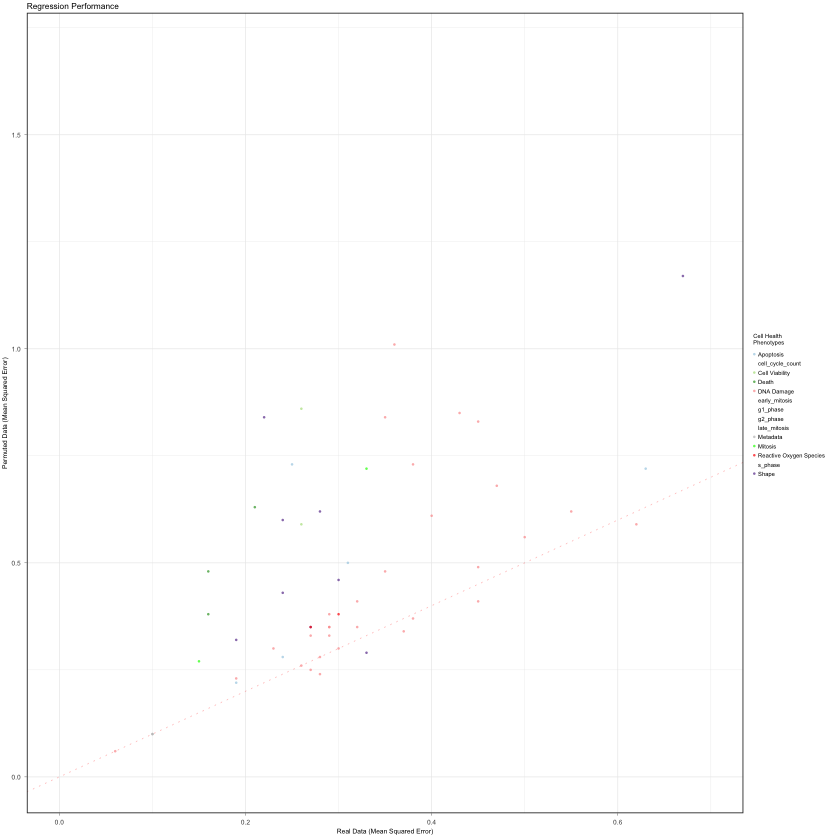

In [11]:
ggplot(mse_spread_df,
       aes(x = Real,
           y = Shuffle,
           color = measurement)) +
    geom_abline(intercept = 0,
                lwd = 0.1,
                slope = 1,
                linetype = "dotted",
                alpha = 0.7,
                color = "red") +
    geom_point(size = 0.4,
               alpha = 0.7,
               pch = 16) +
    xlim(c(0, 0.7)) +
    ylim(c(0, 1.7)) +
    xlab("Real Data (Mean Squared Error)") +
    ylab("Permuted Data (Mean Squared Error)") +
    ggtitle("Regression Performance") +
    theme_bw() +
    dye_theme +
    scale_color_manual(
        name = "Cell Health\nPhenotypes",
        values = measurement_colors,
        labels = measurement_labels
    )

output_file <- file.path(
    figure_dir,
    paste0("mse_comparison_scatter_", consensus, ".png")
)
ggsave(output_file, width = 2, height = 1.5, dpi = 300, units = "in")

### Visualize R^2 Performance

In [12]:
r2_df <- regression_metrics_df %>%
    dplyr::filter(metric == "r_two",
                  y_transform == "raw")

# Sort mse by minimum MSE in test set
target_order <- r2_df %>%
    dplyr::filter(data_type == "Test",
                  shuffle == "Real") %>%
    dplyr::arrange(value) %>%
    dplyr::select(target)

r2_df$target <- factor(r2_df$target, levels=target_order$target)

head(r2_df, 4)

value,metric,target,data_type,shuffle,y_transform,cell_line
<dbl>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>
0.47,r_two,cc_all_high_h2ax,Train,Shuffle,raw,all
0.03,r_two,cc_all_high_h2ax,Test,Shuffle,raw,all
0.47,r_two,cc_all_high_h2ax,Train,Real,raw,all
0.33,r_two,cc_all_high_h2ax,Test,Real,raw,all


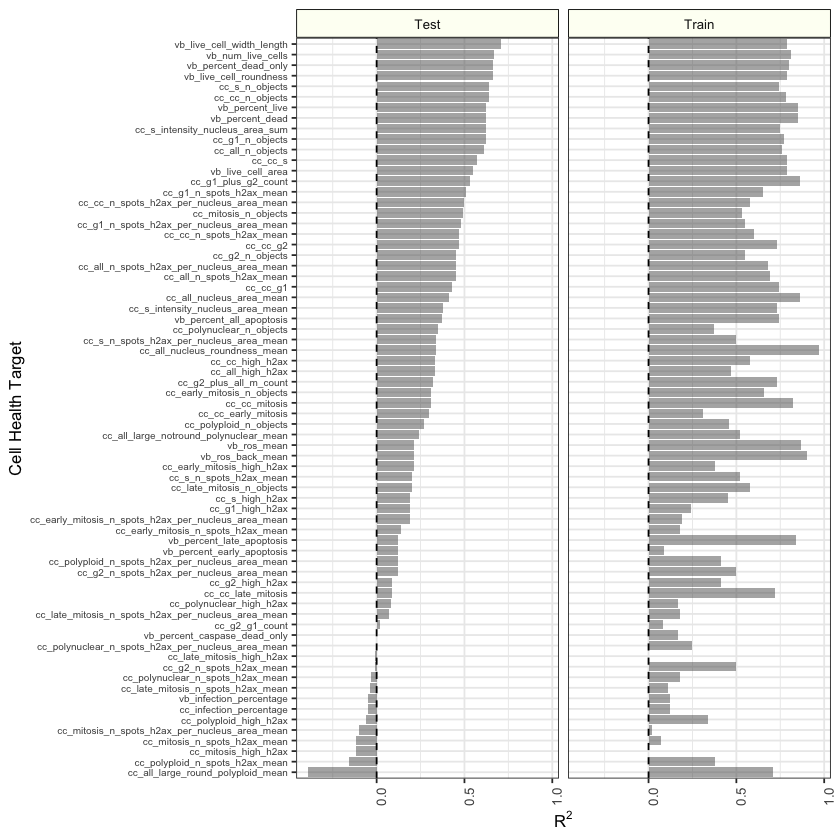

In [13]:
ggplot(r2_df %>% dplyr::filter(shuffle == "Real"),
       aes(x = target,
           y = value)) +
    geom_bar(stat = "identity",
             alpha = 0.5,
             position = position_dodge()) +
    facet_grid(~data_type, scales = "free_y") +
    coord_flip() +
    theme_bw() +
    geom_hline(yintercept = 0, linetype = "dashed") +
    ylab(bquote(R^2)) +
    xlab("Cell Health Target") +
    theme(axis.text.x = element_text(size = 8, angle = 90),
          axis.text.y = element_text(size = 6),
          axis.title = element_text(size = 10),
          legend.position = "none",
          legend.text = element_text(size = 7),
          legend.title = element_text(size = 9),
          strip.text = element_text(size = 8),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

file <- file.path(
    figure_dir,
    paste0("r_squared_model_summary_", consensus, ".png")
)
ggsave(file, dpi = 300, width = 6, height = 6)

In [14]:
# Merge table with target labels
r2_summary_df <- r2_df %>%
    dplyr::left_join(label_df, by = c("target" = "id")) %>%
    dplyr::filter(!is.na(measurement))

# Split shuffle column for scatter plot
r2_spread_df <- r2_summary_df %>% tidyr::spread(shuffle, value)

head(r2_spread_df, 2)

Warning message:
“Column `target`/`id` joining factor and character vector, coercing into character vector”

metric,target,data_type,y_transform,cell_line,readable_name,original_name,feature_type,measurement,gate_required,⋯,edu,ph3,gh2ax,caspase,draq7,cell_rox,dpc,description,Real,Shuffle
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>
r_two,cc_all_high_h2ax,Train,raw,all,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,⋯,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,0.47,0.47
r_two,cc_all_high_h2ax,Test,raw,all,ALL - % High gH2AX Spots,ALL - High number of spots gH2AX - Mean per Well,cell_cycle,dna_damage,0,⋯,0,0,1,0,0,0,0,Within all cells: fraction of cells containing more than 3 gH2AX spots,0.33,0.03


Warning message:
“Removed 30 rows containing missing values (geom_point).”Warning message:
“Removed 30 rows containing missing values (geom_point).”

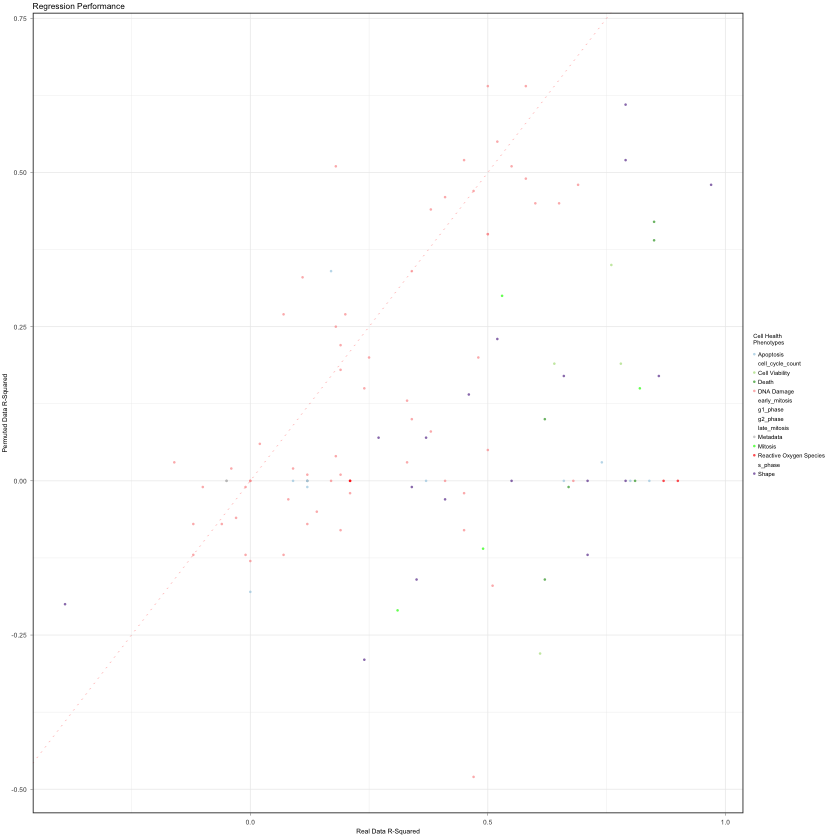

In [15]:
ggplot(r2_spread_df,
       aes(x = Real,
           y = Shuffle,
           color = measurement)) +
    geom_abline(intercept = 0,
                lwd = 0.1,
                slope = 1,
                linetype = "dotted",
                alpha = 0.7,
                color = "red") +
    geom_point(size = 0.4,
               alpha = 0.7,
               pch = 16) +
    xlab(bquote("Real Data R-Squared")) +
    ylab(bquote("Permuted Data R-Squared")) +
    ggtitle("Regression Performance") +
    theme_bw() +
    dye_theme +
    scale_color_manual(
        name = "Cell Health\nPhenotypes",
        values = measurement_colors,
        labels = measurement_labels
    )

output_file <- file.path(
    figure_dir,
    paste0("r_squared_comparison_scatter_", consensus, ".png")
)
ggsave(output_file, width = 2, height = 1.5, dpi = 300, units = "in")

## Plot performance metrics for each target variable

In [16]:
label_thresh_value = 0.925

pdf_file <- file.path(
    figure_dir,
    paste0("all_regression_performance_metrics_", consensus, ".pdf")
)
pdf(pdf_file, width = 6, height = 8, onefile = TRUE)

for (target in unique(y_plot_df$target)) {
    # Subset all dataframes
    y_subset_df <- y_plot_df %>% dplyr::filter(target == !!target)
    
    y_subset_df$shuffle <- y_subset_df$shuffle %>%
        dplyr::recode_factor("shuffle_false" = "Real",
                             "shuffle_true" = "Permuted")
    
    coef_subset_df <- full_coef_df %>%
        dplyr::filter(target == !!target)
    metrics_subset_df <- regression_metrics_df %>%
        dplyr::filter(target == !!target)
    
    for (y_transform in unique(y_subset_df$y_transform)) {
        y_subset_transform_df <- y_subset_df %>%
            dplyr::filter(y_transform == !!y_transform)
        
        coef_subset_transform_df <- coef_subset_df %>%
            dplyr::filter(y_transform == !!y_transform,
                          shuffle == "shuffle_false") %>%
            dplyr::mutate(weight_rank = row_number(weight))
        
        metrics_subset_transform_df <- metrics_subset_df %>%
            dplyr::filter(y_transform == !!y_transform)
        
        pred_scatter_gg <-
           ggplot(y_subset_transform_df,
                  aes(x = recode_target_value_true,
                      y = recode_target_value_pred)) +
                geom_point(aes(color = Metadata_cell_line),
                           size = 0.5, alpha = 0.8) +
                facet_grid(data_type~shuffle) +
                theme_bw() +
                xlab("True Values") +
                ylab("Predicted Values") +
                scale_color_manual(name = "Cell Line",
                                   labels = c("A549" = "A549",
                                              "ES2" = "ES2",
                                              "HCC44" = "HCC44"),
                                   values = c("A549" = "#7fc97f",
                                              "ES2" = "#beaed4",
                                              "HCC44" = "#fdc086")) +
                geom_smooth(method='lm', formula=y~x) +
                theme(strip.text = element_text(size = 10),
                      strip.background = element_rect(colour = "black",
                                                      fill = "#fdfff4"))
        
        # Setup labeling thresholds
        non_zero_coef <- coef_subset_transform_df$abs_weight[coef_subset_transform_df$abs_weight > 0]
        label_thresh <- quantile(non_zero_coef, label_thresh_value)
        label_logic <- coef_subset_transform_df$abs_weight > label_thresh

        coef_gg <-
            ggplot(coef_subset_transform_df,
                   aes(x = weight_rank,
                       y = weight)) +
                geom_point(size = 0.2,
                           alpha = 0.6) +
                xlab("Weight Rank") +
                ylab("Weight") +
                geom_text_repel(
                    data = subset(coef_subset_transform_df, label_logic),
                    arrow = arrow(length = unit(0.01, "npc")),
                    box.padding = 0.4,
                    point.padding = 0.1,
                    segment.size = 0.5,
                    segment.alpha = 0.6,
                    size = 1.5,
                    fontface = "italic",
                    aes(label = feature,
                        x = weight_rank,
                        y = weight)) +
                theme_bw()
        
         # Build table for plotting performance metrics
        mse_df <- metrics_subset_transform_df %>%
            dplyr::filter(metric == "mse") %>%
            dplyr::select(-metric)
        mse_df$value = abs(mse_df$value)

        r2_df <- metrics_subset_transform_df %>%
            dplyr::filter(metric == "r_two") %>%
            dplyr::rename(r2 = value) %>%
            dplyr::select(-metric)

        metric_table_df <- r2_df %>%
            dplyr::inner_join(mse_df,
                              by=c("target", "data_type", "shuffle", "y_transform")) %>%
            dplyr::select(data_type, shuffle, y_transform, r2, value) %>%
            dplyr::rename(fit = data_type, transform = y_transform) %>%
            dplyr::arrange(shuffle)

        metric_table_df$shuffle <- dplyr::recode(
            metric_table_df$shuffle,
            shuffle_true = "True",
            shuffle_false = "False"
        )

        # Plot all performance metrics together with cowplot
        table_theme <- gridExtra::ttheme_default(
            core = list(fg_params=list(cex = 0.7)),
            colhead = list(fg_params=list(cex = 0.8))
        )

        table_gg <- gridExtra::tableGrob(metric_table_df,
                                         theme = table_theme,
                                         rows = NULL)
        
        bottom_row_gg <- cowplot::plot_grid(
            table_gg,
            coef_gg,
            rel_widths = c(0.8, 1),
            nrow = 1
        )
        regression_perf_gg <- cowplot::plot_grid(
            pred_scatter_gg,
            bottom_row_gg,
            rel_heights = c(1, 0.8),
            nrow = 2
        )
        
        target_title <- cowplot::ggdraw() + 
          cowplot::draw_label(
            paste("Performance:", target, "\nTransform:", y_transform),
            fontface = 'bold',
            x = 0,
            hjust = 0
          ) +
          theme(
            plot.margin = margin(0, 0, 0, 7)
          )

        regression_perf_gg <- cowplot::plot_grid(
            target_title,
            regression_perf_gg,
            ncol = 1,
            rel_heights = c(0.1, 1)
        )
        
        # Save figure
        cowplot_file <- file.path(
            individual_fig_dir,
            paste0(target, "_", y_transform, "_performance_", consensus, ".png")
        )

        cowplot::save_plot(
            filename = cowplot_file,
            plot = regression_perf_gg,
            base_height = 6,
            base_width = 6
        )
        
        print(regression_perf_gg)
    }
}

dev.off()

pdf 
  2